<div style="text-align: right">CSYE 7380 </div>
<div style="text-align: right">Final Project</div>

# Generating images of specific digits with Stable Diffusion Model

## Overview
This notebook implements a **Diffusion Model** from scratch in PyTorch to generate MNIST digit images.
The core idea is to start with a clean digit image using UNet and Scheduler.

## Key Components

- **MNIST Dataset Loader** → loads grayscale 28×28 digit images.  
- **DDPM_Schedule** → handles forward noise addition & parameters for reverse process.  
- **Model** → a small neural network predicting noise at each timestep.  
- **Training Loop** → optimizes the model to minimize noise prediction error.  
- **Sampling Loop** → generates new digits from random noise using the trained model.  
- **Schedule Options** → supports both *DDPM* and *DDIM*.  

**Link to Dataset Used**: [**MNIST Dataset**](https://en.wikipedia.org/wiki/MNIST_database)


## Goal
To build a stable diffusion model from scratch which can can generate digits from pure noise.

---

<div style="text-align: right">  
<strong>Akshit Hasmukh Kumar Jain</strong> - 002876444
</div>

## Importing Libraries

In [1]:
# !pip -q install torch torchvision'
# Load core libraries, set device (GPU/CPU), and basic utilities.
import math, random, os, time
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
import matplotlib.pyplot as plt

## Environment Setup

In [2]:
# Check device
if torch.cuda.is_available():
    device = torch.device('cuda')
    num_gpus = torch.cuda.device_count()
    gpu_name = torch.cuda.get_device_name(0)
    print(f"Using GPU: {gpu_name} | Total GPUs Available: {num_gpus}")
else:
    device = torch.device('cpu')
    print("Using CPU (No GPU detected)")

print("Current Device:", device)

Using GPU: Tesla T4 | Total GPUs Available: 1
Current Device: cuda


## Data Loading (MNIST 28×28, grayscale) & Preprocessing

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.26MB/s]


Total MNIST samples: 70000


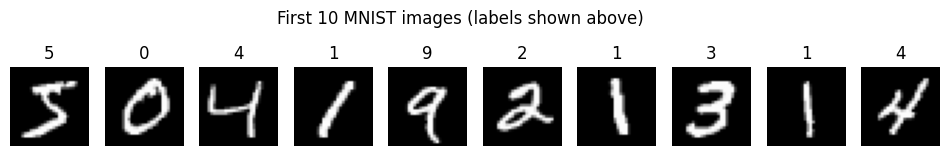

Train samples: 60000


In [3]:
batch_size = 128
image_size = 28
transform = transforms.Compose([
    transforms.ToTensor(),                # [0,1]
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

# Load datasets
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for training
train_dl = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# 1. Total images in MNIST
total_images = len(mnist_train_dataset) + len(mnist_test_dataset)
print(f"Total MNIST samples: {total_images}")

# 2. Show first 10 images from train set
fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i in range(10):
    img, label = mnist_train_dataset[i]
    img = (img * 0.5 + 0.5).clamp(0, 1)  # denormalize to [0,1]
    axes[i].imshow(img.squeeze(0), cmap="gray")
    axes[i].set_title(str(label))
    axes[i].axis("off")
plt.suptitle("First 10 MNIST images (labels shown above)")
plt.show()

# 3. Print train sample count
print('Train samples:', len(mnist_train_dataset))


## Time & label embeddings

In [4]:
## 3) Time & Label Embeddings

def create_sinusoidal_time_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal position/time embeddings for diffusion timesteps.

    In diffusion models, the model must know *when* it is in the diffusion process.
    This function encodes a scalar timestep `t` into a higher-dimensional vector
    using sine and cosine functions of different frequencies.

    Args:
        timesteps (torch.Tensor): Tensor of shape (batch_size,) containing integer timesteps.
        embedding_dim (int): Dimension of the output embedding vector.

    Returns:
        torch.Tensor: Shape (batch_size, embedding_dim), containing the time embeddings.
    """
    device = timesteps.device
    half_dim = embedding_dim // 2
    frequencies = torch.exp(
        -math.log(10000) * torch.arange(half_dim, device=device) / (half_dim - 1)
    )
    angles = timesteps[:, None].float() * frequencies[None]
    embedding = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
    if embedding_dim % 2 == 1:  # If odd, pad one extra dimension
        embedding = F.pad(embedding, (0, 1))
    return embedding


class TimeEmbeddingMLP(nn.Module):
    """
    Projects the sinusoidal time embedding into a richer representation
    via a small MLP (Multi-Layer Perceptron).
    """
    def __init__(self, embedding_dim, projection_dim):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.network = nn.Sequential(
            nn.Linear(embedding_dim, projection_dim),
            nn.SiLU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, timesteps):
        time_emb = create_sinusoidal_time_embedding(timesteps, self.embedding_dim)
        return self.network(time_emb)


class ClassLabelEmbedding(nn.Module):
    """
    Learnable embedding layer for digit class conditioning (0–9).
    """
    def __init__(self, num_classes, embedding_dim):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_classes, embedding_dim)

    def forward(self, labels):
        return self.embedding_layer(labels)

## U-Net MNIST (for 28×28 grayscale)
Minimal U-Net with residual blocks, down/up-sampling, skip connections, time and label conditioning.

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, emb):
        h = self.conv1(self.act1(self.norm1(x)))
        h = h + self.emb_proj(emb)[:, :, None, None]
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.skip(x)

class Down(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.pool = nn.Conv2d(ch, ch, 3, stride=2, padding=1)
    def forward(self, x):
        return self.pool(x)

class Up(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)
    def forward(self, x):
        return self.conv(self.up(x))

class UNetMNIST(nn.Module):
    """
    A simplified U-Net architecture for MNIST image denoising and generation,
    with optional class conditioning and timestep embeddings for diffusion models.

    This model follows the encoder–bottleneck–decoder structure:
    - Downsampling path: progressively reduces spatial dimensions while increasing channels.
    - Bottleneck: two residual blocks processing the most compressed feature map.
    - Upsampling path: progressively restores spatial dimensions, with skip connections to
      preserve high-frequency details.
    """
    def __init__(self, in_ch=1, base=64, time_dim=128, num_classes=10, class_cond=True):
        super().__init__()
        self.class_cond = class_cond
        self.time_mlp = TimeEmbeddingMLP(embedding_dim=64, projection_dim=time_dim)
        self.label_mlp = ClassLabelEmbedding(num_classes, time_dim) if class_cond else None

        self.in_conv = nn.Conv2d(in_ch, base, 3, padding=1)
        self.rb1 = ResBlock(base, base, time_dim)
        self.down1 = Down(base)
        self.rb2 = ResBlock(base, base*2, time_dim)
        self.down2 = Down(base*2)
        self.rb3 = ResBlock(base*2, base*2, time_dim)
        self.mid1 = ResBlock(base*2, base*2, time_dim)
        self.mid2 = ResBlock(base*2, base*2, time_dim)
        self.up1 = Up(base*2)
        self.rb4 = ResBlock(base*2, base*2, time_dim)
        self.up2 = Up(base*2)
        self.rb5 = ResBlock(base*3, base, time_dim)
        self.out_norm = nn.GroupNorm(8, base)
        self.out_act = nn.SiLU()
        self.out_conv = nn.Conv2d(base, in_ch, 3, padding=1)
    def forward(self, x, t, y=None):
        t_emb = self.time_mlp(t)
        if self.class_cond:
            if y is None:
                raise ValueError('class_cond=True but y is None')
            emb = t_emb + self.label_mlp(y)
        else:
            emb = t_emb
        x1 = self.rb1(self.in_conv(x), emb)
        d1 = self.down1(x1)
        x2 = self.rb2(d1, emb)
        d2 = self.down2(x2)
        x3 = self.rb3(d2, emb)
        m = self.mid1(x3, emb)
        m = self.mid2(m, emb)
        u1 = self.up1(m) + x2
        u1 = self.rb4(u1, emb)
        u2 = torch.cat([self.up2(u1), x1], dim=1)
        u2 = self.rb5(u2, emb)
        out = self.out_conv(self.out_act(self.out_norm(u2)))
        return out

## DDPM scheduler (linear betas)

In [6]:
class DDPM_Schedule:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.T = timesteps
        betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.betas = betas.to(device)
        self.alphas = alphas.to(device)
        self.alphas_cumprod = alphas_cumprod.to(device)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1].to(device)], dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_ac = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_om = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        return sqrt_ac * x0 + sqrt_om * noise
schedule = DDPM_Schedule(timesteps=1000, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


## Training loop predict noise $\varepsilon$ (DDPM objective)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetMNIST(in_ch=1, base=64, time_dim=128, num_classes=10, class_cond=True).to(device)
optim = torch.optim.AdamW(model.parameters(), lr=2e-4)
epochs = 25
T = schedule.T
def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        b = x.size(0)
        t = torch.randint(0, T, (b,), device=device, dtype=torch.long)
        noise = torch.randn_like(x)
        x_t = schedule.q_sample(x, t, noise)
        eps_pred = model(x_t, t, y)
        loss = F.mse_loss(eps_pred, noise)
        optim.zero_grad(set_to_none=True)
        loss.backward()
        optim.step()
        total_loss += loss.item() * b
    return total_loss / len(mnist_train_dataset)
for e in range(1, epochs+1):
    avg = train_one_epoch(e)
    print(f"Epoch {e}/{epochs} - loss: {avg:.4f}")


Epoch 1/25 - loss: 0.0825
Epoch 2/25 - loss: 0.0347
Epoch 3/25 - loss: 0.0294
Epoch 4/25 - loss: 0.0272
Epoch 5/25 - loss: 0.0260
Epoch 6/25 - loss: 0.0252
Epoch 7/25 - loss: 0.0247
Epoch 8/25 - loss: 0.0243
Epoch 9/25 - loss: 0.0239
Epoch 10/25 - loss: 0.0238
Epoch 11/25 - loss: 0.0234
Epoch 12/25 - loss: 0.0232
Epoch 13/25 - loss: 0.0229
Epoch 14/25 - loss: 0.0229
Epoch 15/25 - loss: 0.0227
Epoch 16/25 - loss: 0.0227
Epoch 17/25 - loss: 0.0227
Epoch 18/25 - loss: 0.0225
Epoch 19/25 - loss: 0.0221
Epoch 20/25 - loss: 0.0220
Epoch 21/25 - loss: 0.0223
Epoch 22/25 - loss: 0.0218
Epoch 23/25 - loss: 0.0216
Epoch 24/25 - loss: 0.0220
Epoch 25/25 - loss: 0.0219


## Samplers: DDPM and DDIM

In [8]:
@torch.no_grad()
def sample_ddpm(n=16, class_label=None):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    y = torch.randint(0, 10, (n,), device=device) if class_label is None else torch.full((n,), int(class_label), device=device, dtype=torch.long)
    for t in reversed(range(schedule.T)):
        t_batch = torch.full((n,), t, device=device, dtype=torch.long)
        eps = model(x, t_batch, y)
        beta_t = schedule.betas[t]
        sqrt_one_minus_ac = schedule.sqrt_one_minus_alphas_cumprod[t]
        sqrt_recip_alpha = schedule.sqrt_recip_alphas[t]
        mean = sqrt_recip_alpha * (x - beta_t / sqrt_one_minus_ac * eps)
        if t > 0:
            noise = torch.randn_like(x)
            var = schedule.posterior_variance[t]
            x = mean + torch.sqrt(var) * noise
        else:
            x = mean
    return x.clamp(-1, 1)

@torch.no_grad()
def sample_ddim(n=16, class_label=None, ddim_steps=50, eta=0.0):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    y = torch.randint(0, 10, (n,), device=device) if class_label is None else torch.full((n,), int(class_label), device=device, dtype=torch.long)
    T = schedule.T
    ts = torch.linspace(T-1, 0, ddim_steps, dtype=torch.long, device=device)
    for i in range(len(ts)):
        t = ts[i]
        t_batch = torch.full((n,), int(t.item()), device=device, dtype=torch.long)
        alpha_t = schedule.alphas_cumprod[t]
        eps = model(x, t_batch, y)
        x0_pred = (x - torch.sqrt(1 - alpha_t) * eps) / torch.sqrt(alpha_t)
        if i == len(ts) - 1:
            x = x0_pred
            break
        t_next = ts[i+1]
        alpha_next = schedule.alphas_cumprod[t_next]
        sigma = eta * torch.sqrt((1 - alpha_next)/(1 - alpha_t) * (1 - alpha_t/alpha_next))
        dir_xt = torch.sqrt(1 - alpha_next) * eps
        x = torch.sqrt(alpha_next) * x0_pred + dir_xt + sigma * torch.randn_like(x)
    return x.clamp(-1, 1)


## Demo: Unconditional samples

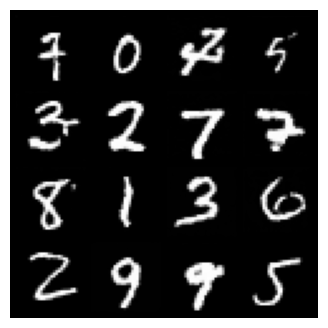

In [ ]:
with torch.no_grad():
    imgs = sample_ddpm(n=16)
grid = vutils.make_grid((imgs+1)/2, nrow=4)
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.axis('off')
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.show()


## Demo: Class-conditional samples (pick a digit)

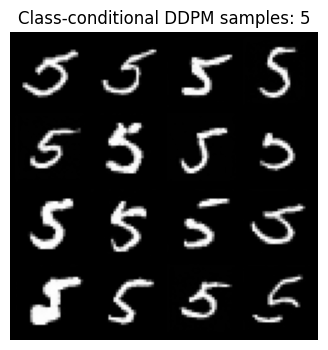

In [10]:
digit = 5  # change this (0-9)
with torch.no_grad():
    imgs = sample_ddpm(n=16, class_label=digit)
grid = vutils.make_grid((imgs+1)/2, nrow=4)
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.axis('off')
plt.title(f'Class-conditional DDPM samples: {digit}')
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.show()


## DDIM faster sampling

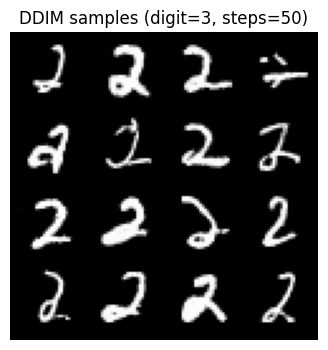

In [11]:
with torch.no_grad():
    imgs = sample_ddim(n=16, class_label=2, ddim_steps=50, eta=0.0)
grid = vutils.make_grid((imgs+1)/2, nrow=4)
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.axis('off')
plt.title('DDIM samples (digit=3, steps=50)')
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.show()


## Save/Load

In [12]:
ckpt_path = 'mnist_diffusion_unet.pt'
def save_model(path=ckpt_path):
    torch.save({'model': model.state_dict()}, path)
    print('Saved to', path)
def load_model(path=ckpt_path):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state['model'])
    print('Loaded from', path)


In [ ]:
import gradio as gr
import numpy as np
import torchvision.utils as vutils
import torch

# Optional: Create a custom theme
custom_theme = gr.themes.Base(
    primary_hue="blue",
    secondary_hue="slate"
)

@torch.no_grad()
def generate_digit_ui(digit=7, method='ddpm', steps=50, n=16):
    digit = int(np.clip(digit, 0, 9))
    if method == 'ddpm':
        imgs = sample_ddpm(n=n, class_label=digit)
    else:
        imgs = sample_ddim(n=n, class_label=digit, ddim_steps=steps, eta=0.0)
    grid = vutils.make_grid((imgs+1)/2, nrow=int(n**0.5))
    np_img = np.transpose(grid.cpu().numpy(), (1,2,0))
    return np_img

demo = gr.Interface(
    fn=generate_digit_ui,
    inputs=[
        gr.Number(value=7, label="Digit (0–9)"),
        gr.Radio(["ddpm", "ddim"], value="ddpm", label="Sampler"),
        gr.Slider(10, 200, value=50, step=10, label="DDIM Steps"),
        gr.Slider(4, 64, value=16, step=4, label="Number of Images")
    ],
    outputs=gr.Image(type="numpy", label="Generated Grid"),
    title="MNIST Diffusion Sampler",
    description="Enter a digit, choose DDPM or DDIM, and generate samples from noise.",
    theme=custom_theme
)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://2d31bacafe82b1b539.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
